In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import emcee
import os

import sys
sys.path.insert(0, '../')

from scipy.ndimage import median_filter as medfilt

n_cadences = 3#int(24 * 60 * 0.5) #  a day

def median_filter(x, n_cadences=n_cadences):
    return medfilt(x, (n_cadences, ))

from libra import k62_all_transits

In [3]:
from interpacf import interpolated_acf

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less
/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in greater


140


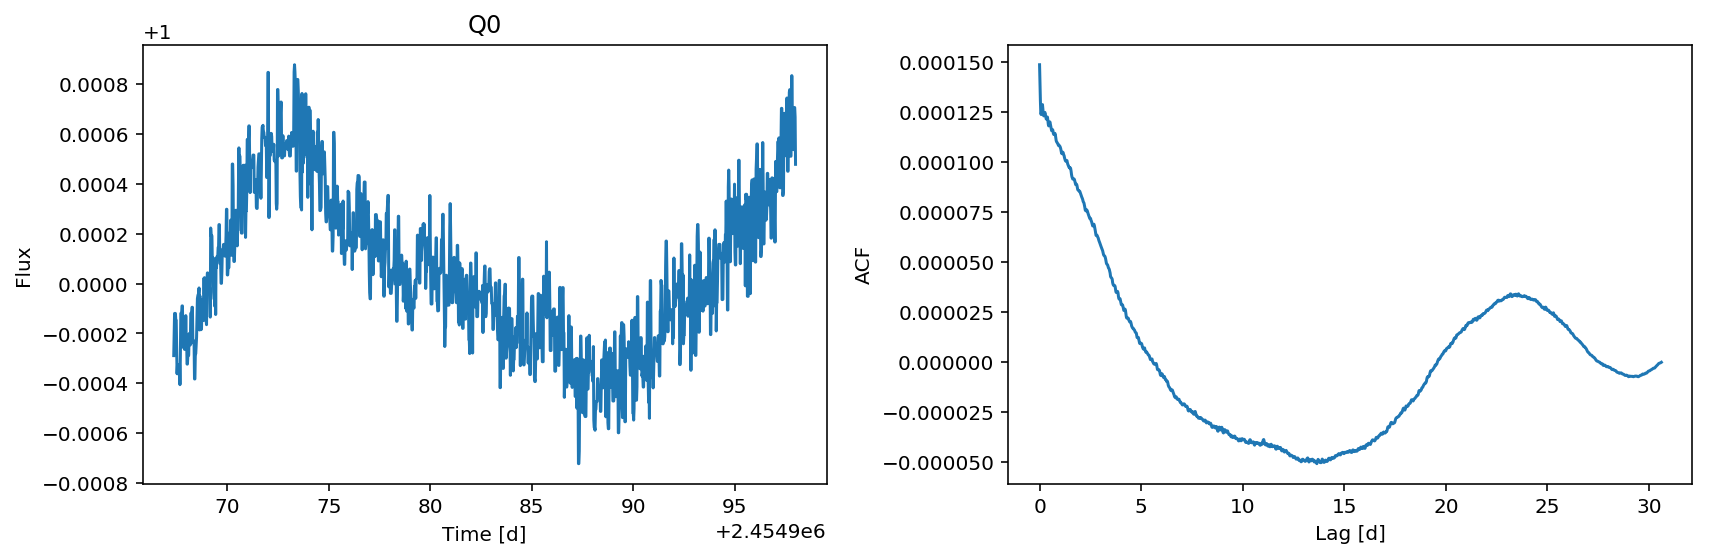

286


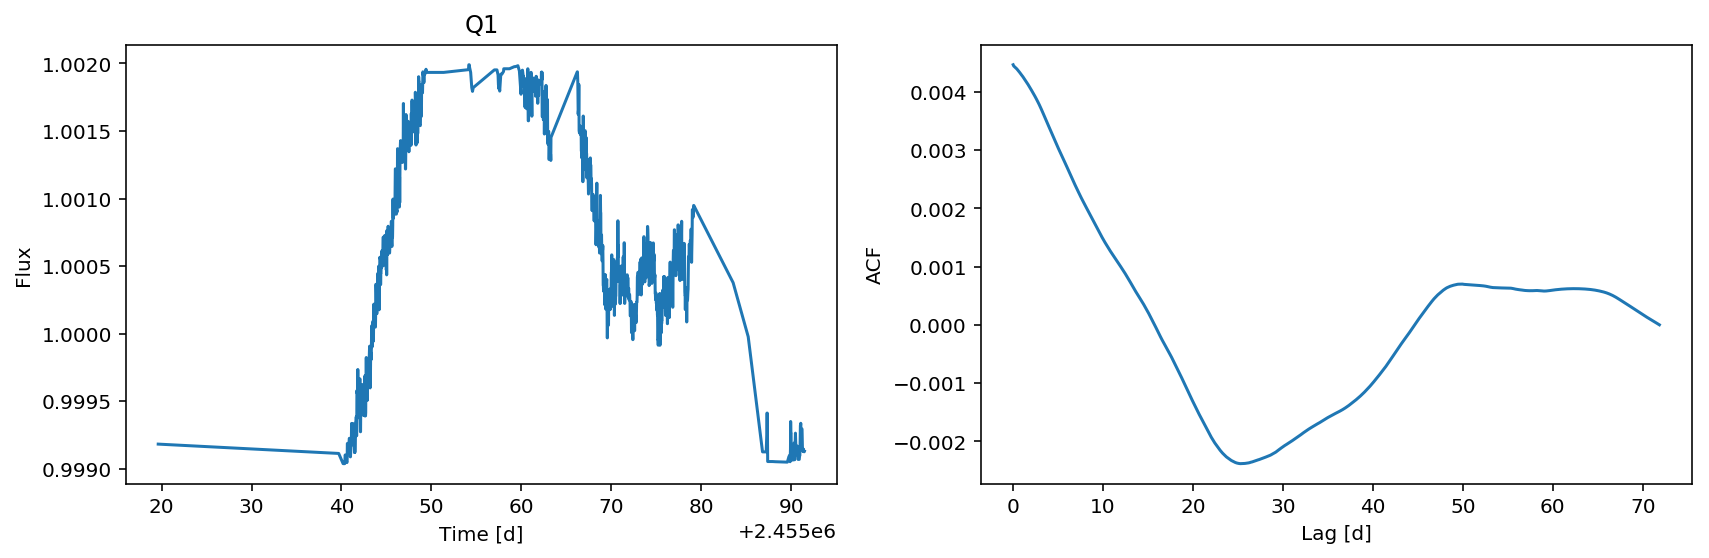

2872


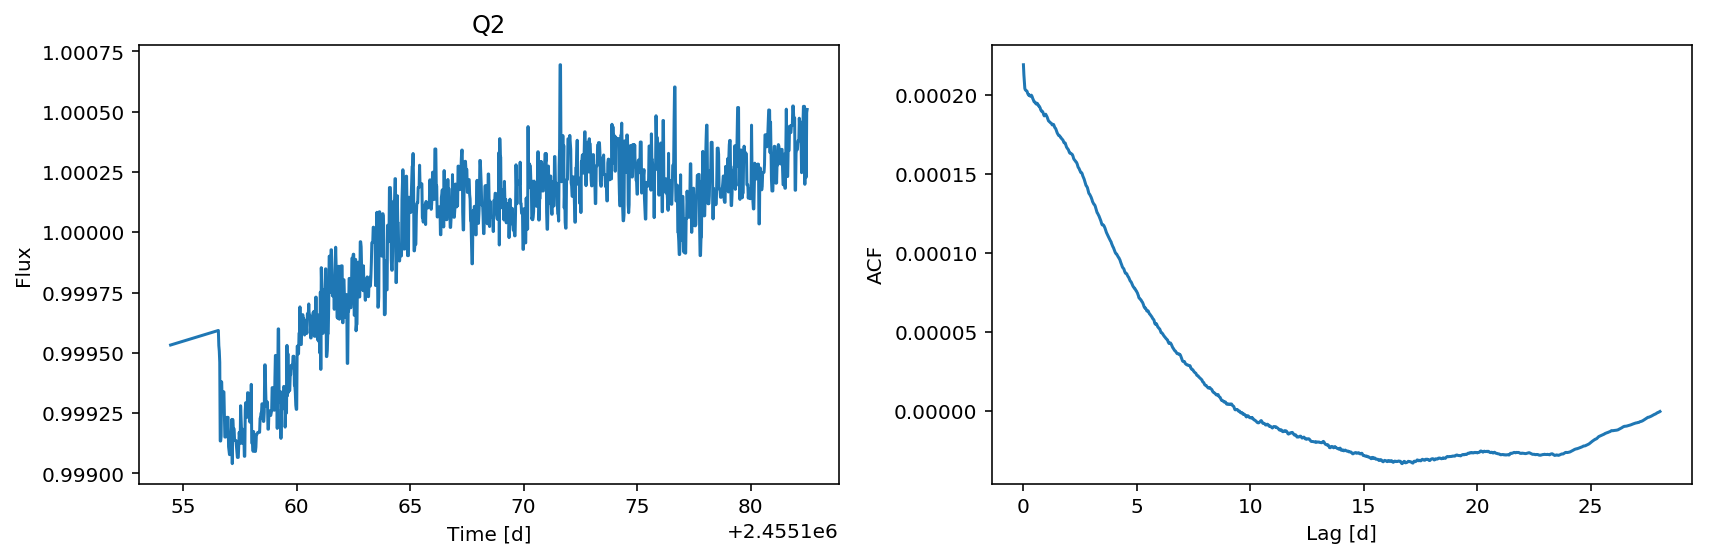

2109


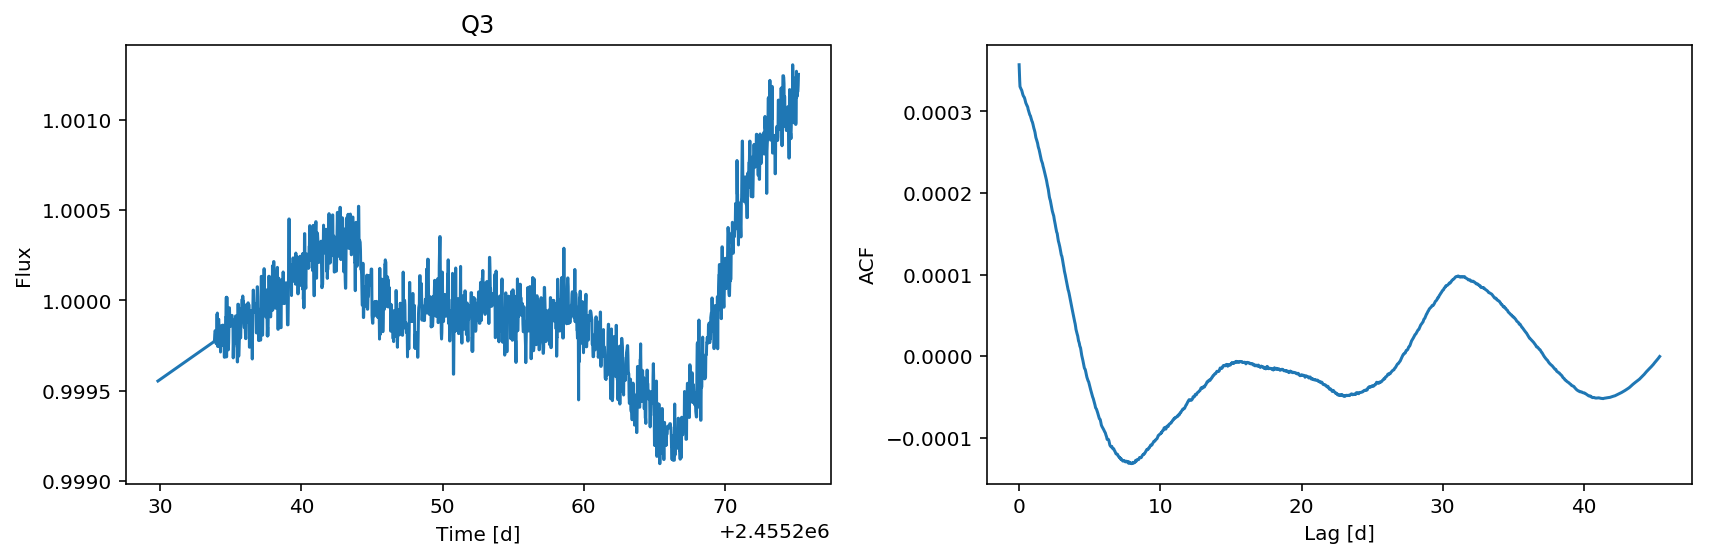

1321


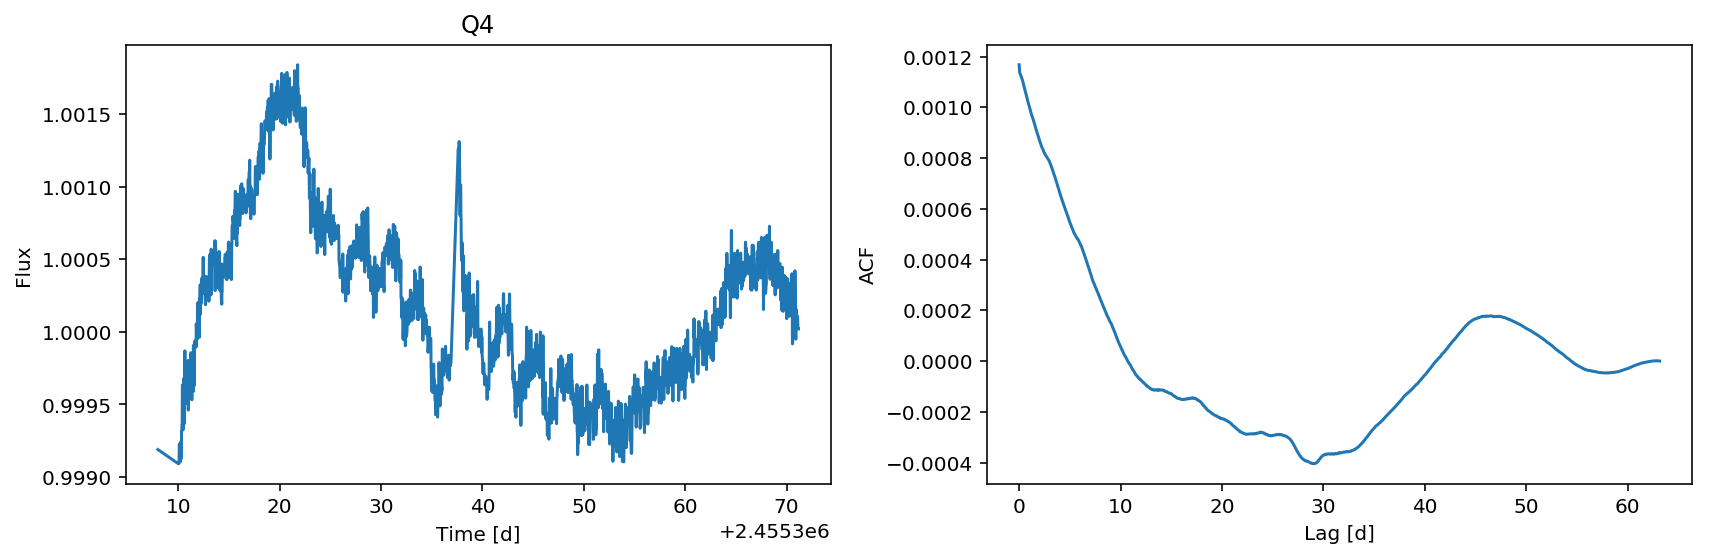

470


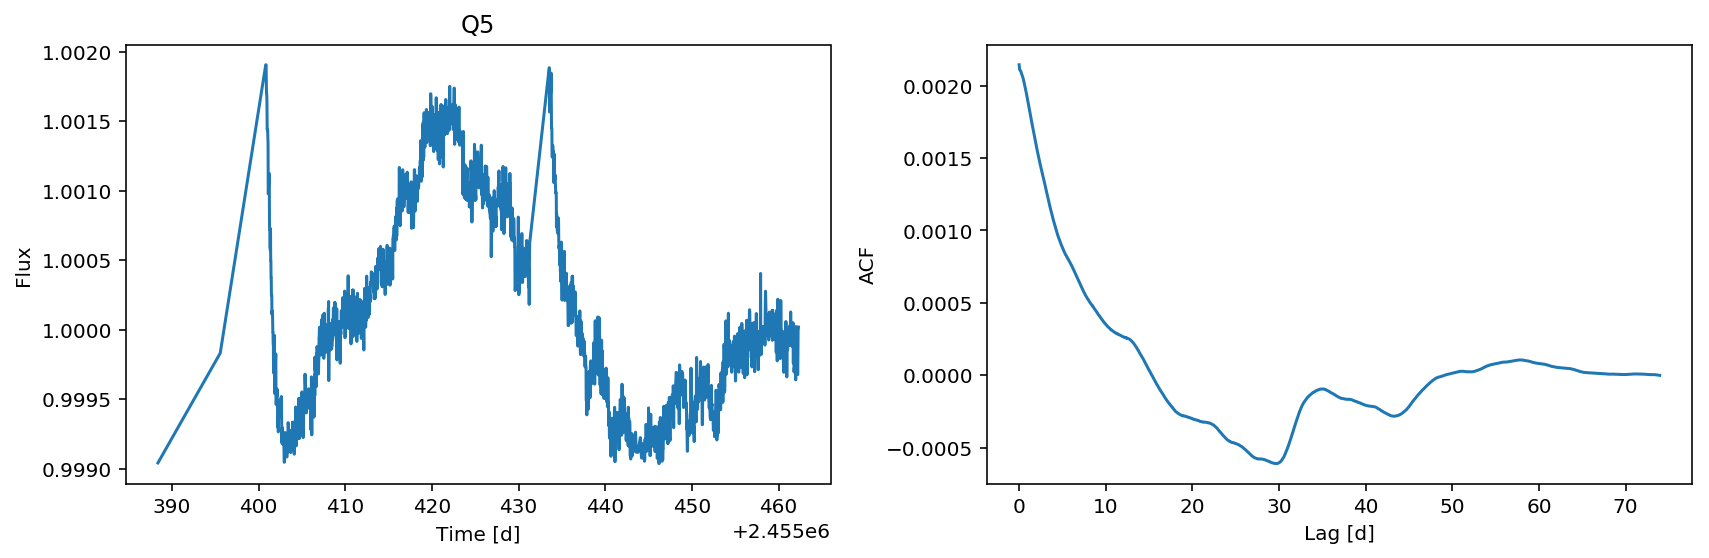

2862


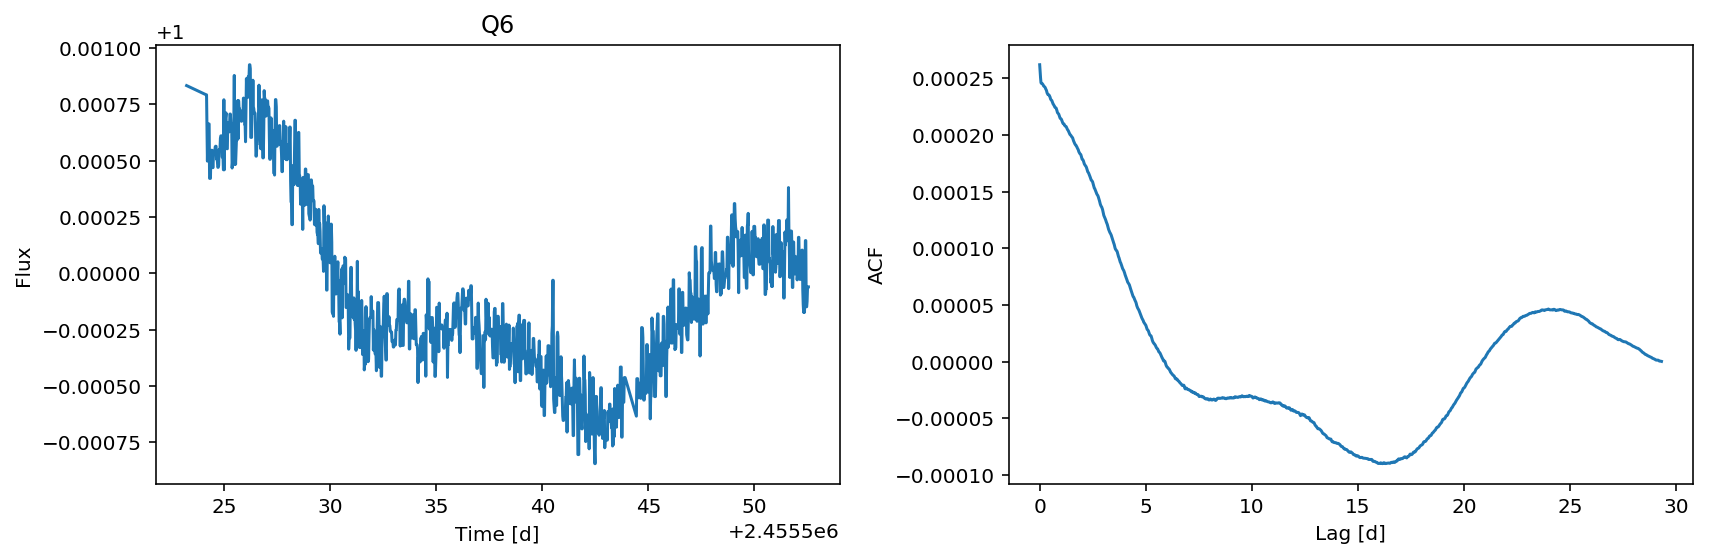

1218


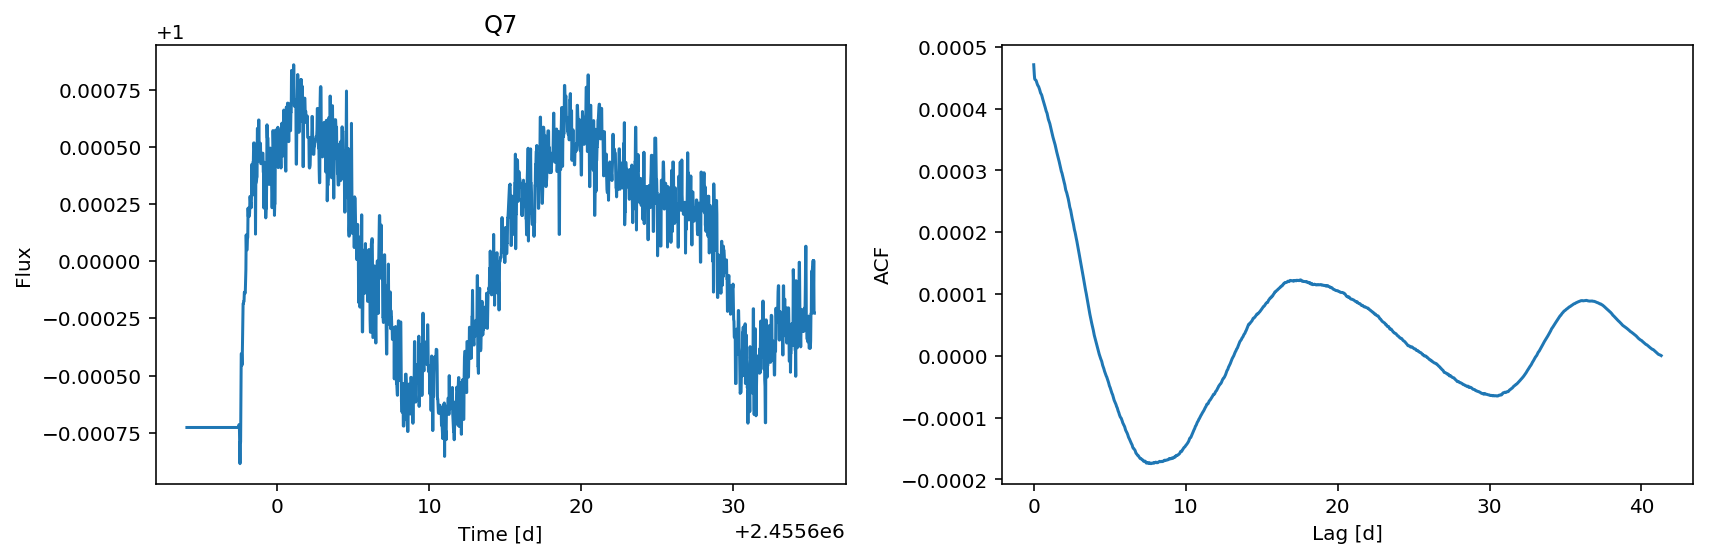

1624


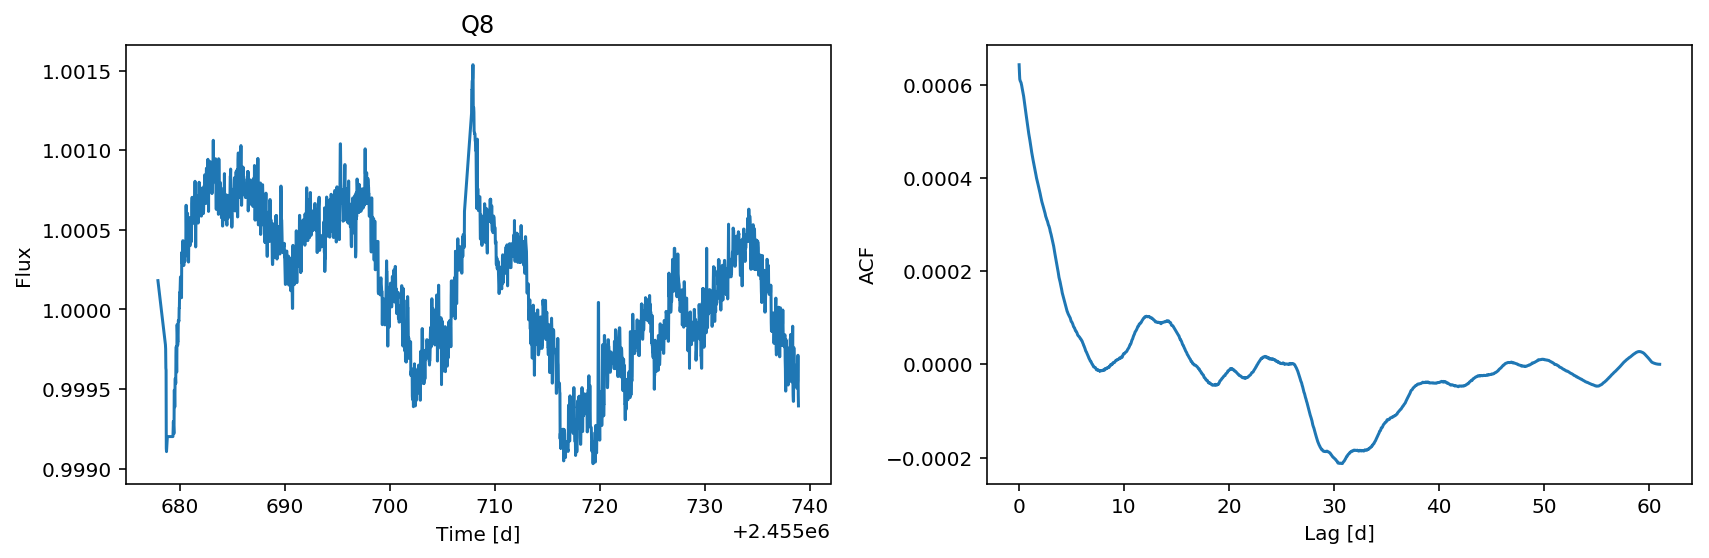

341


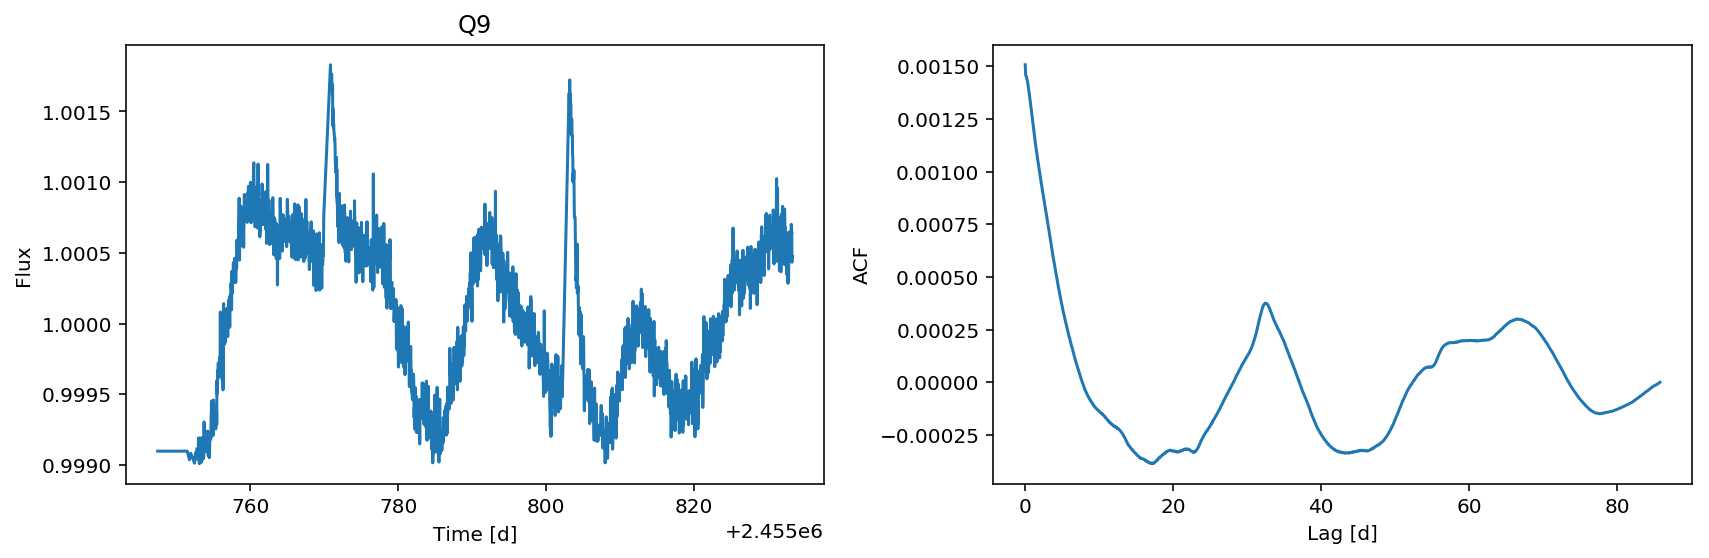

2971


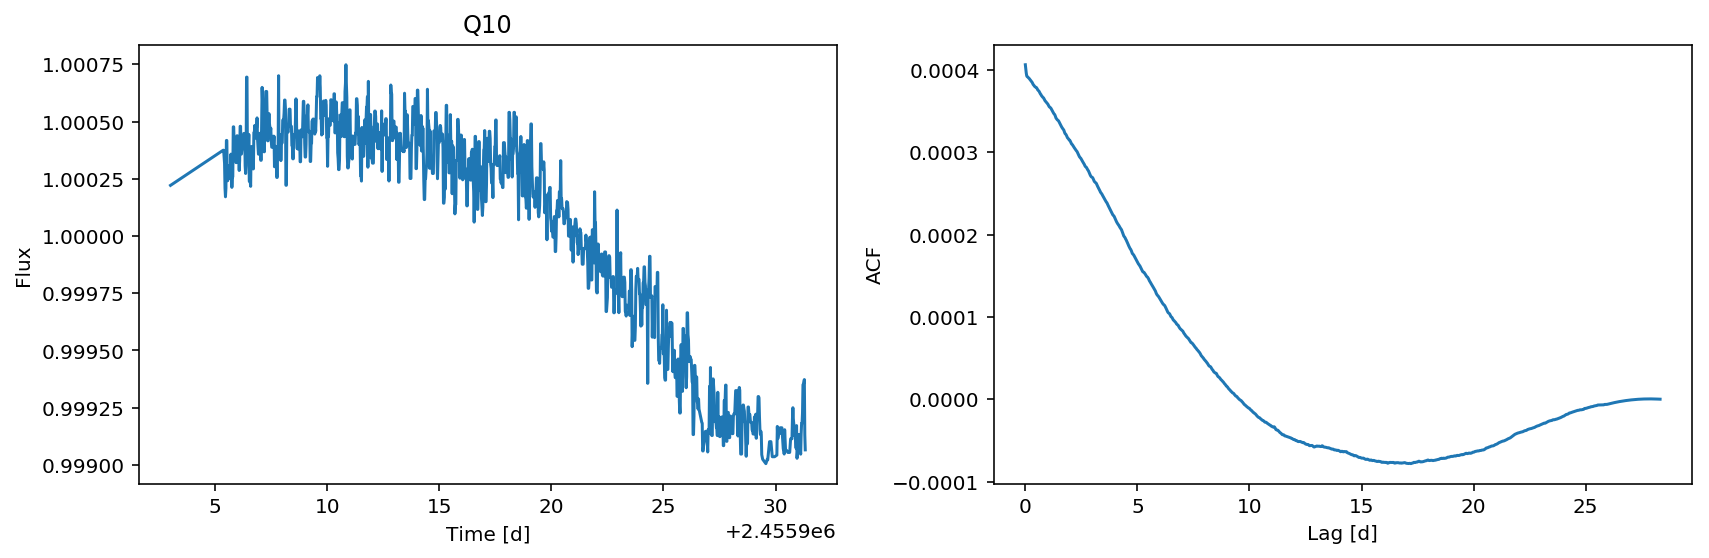

2592


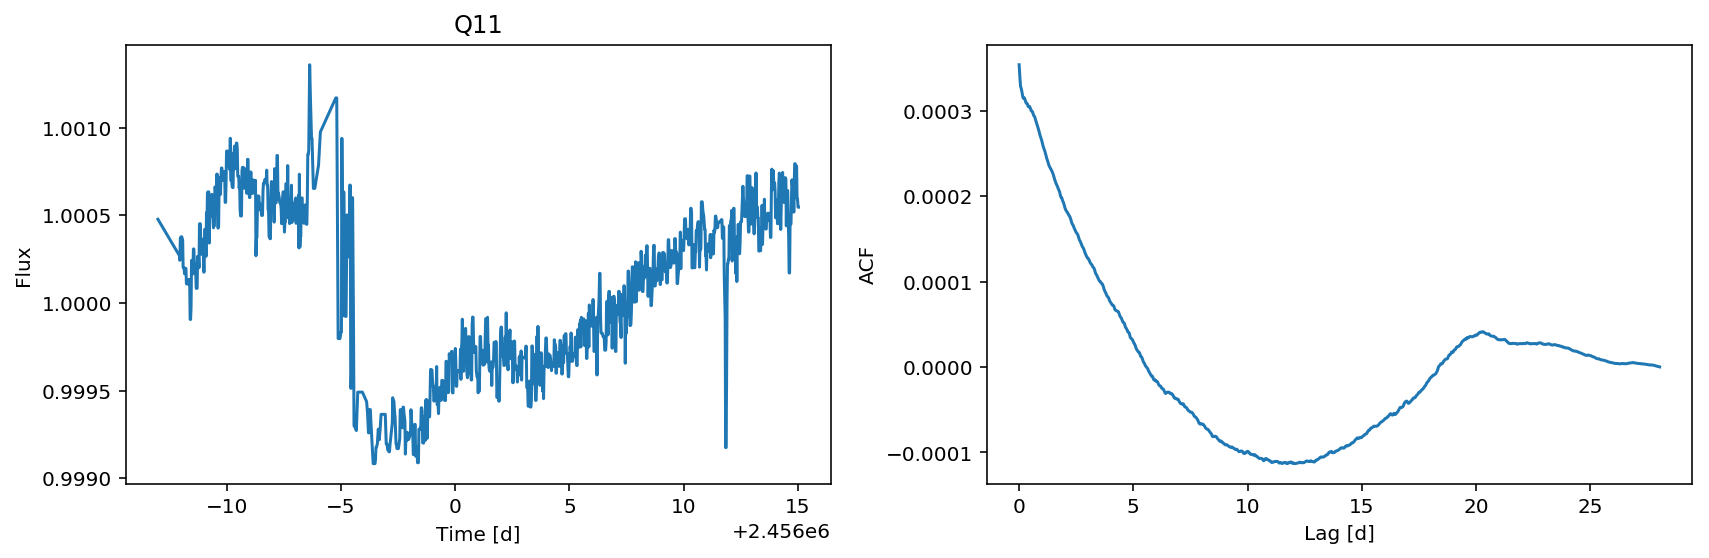

848


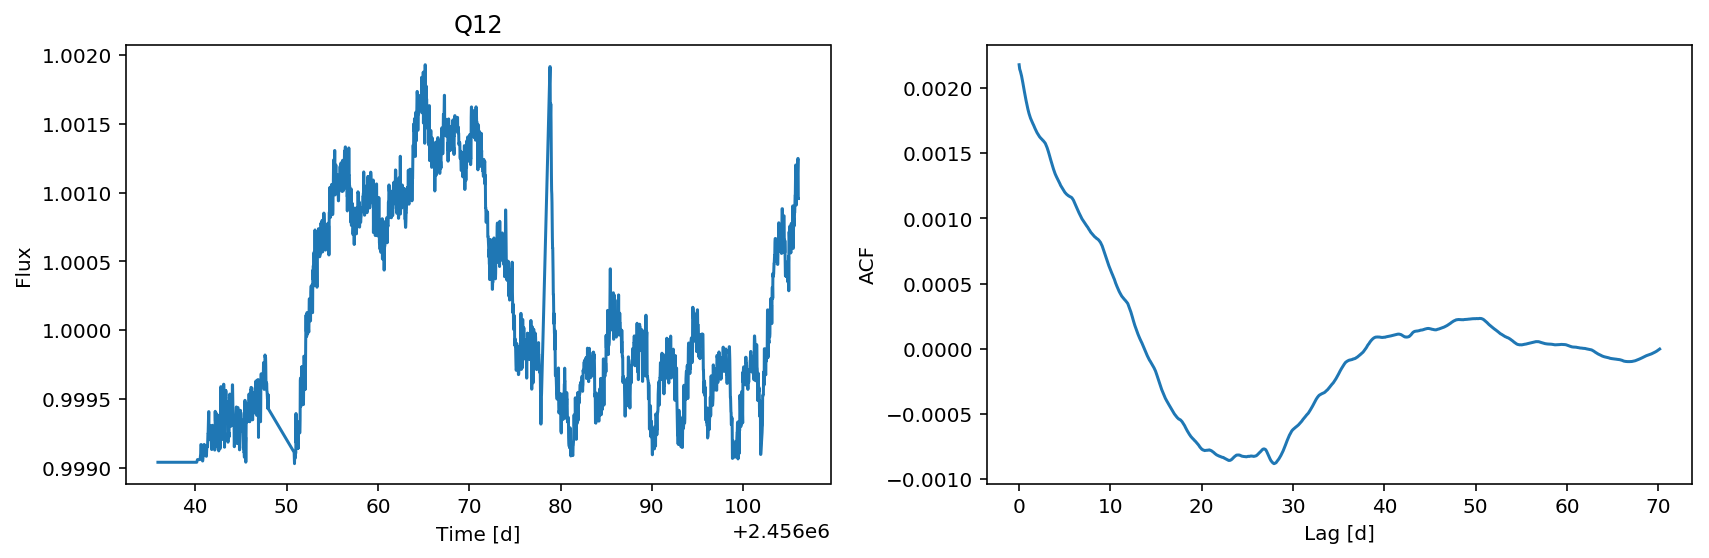

746


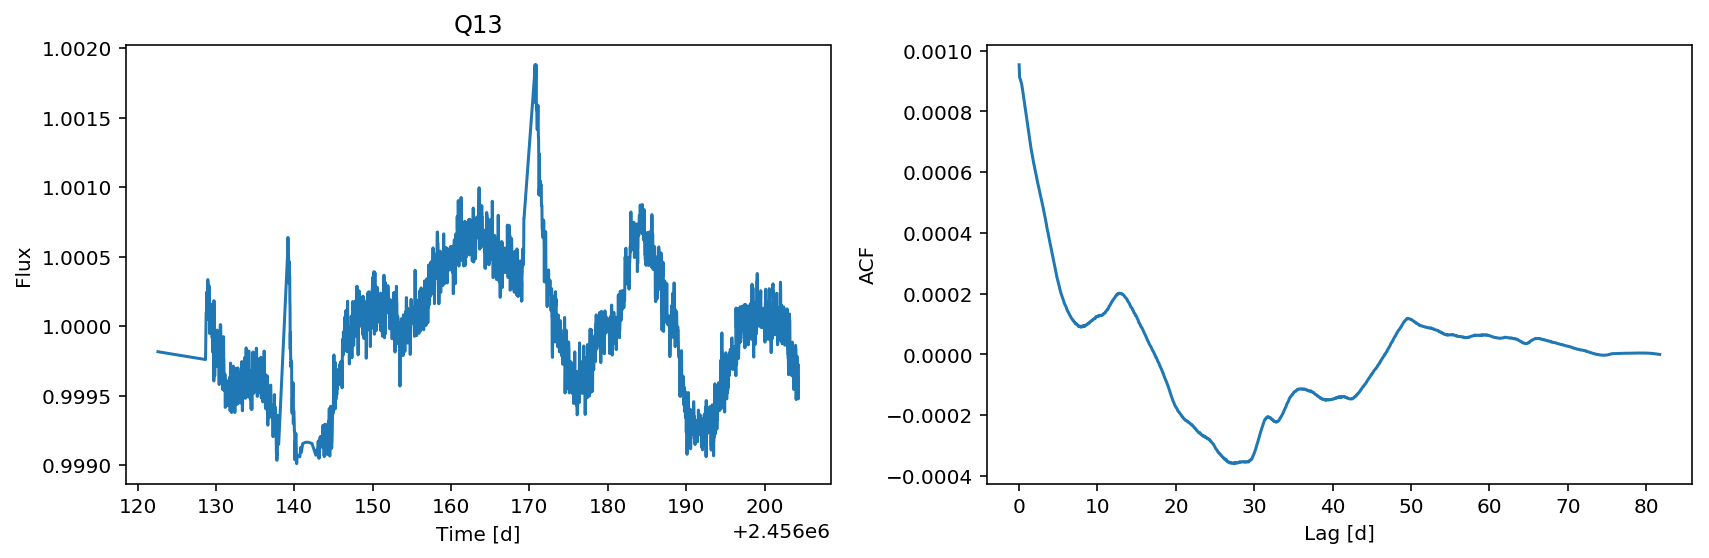

1646


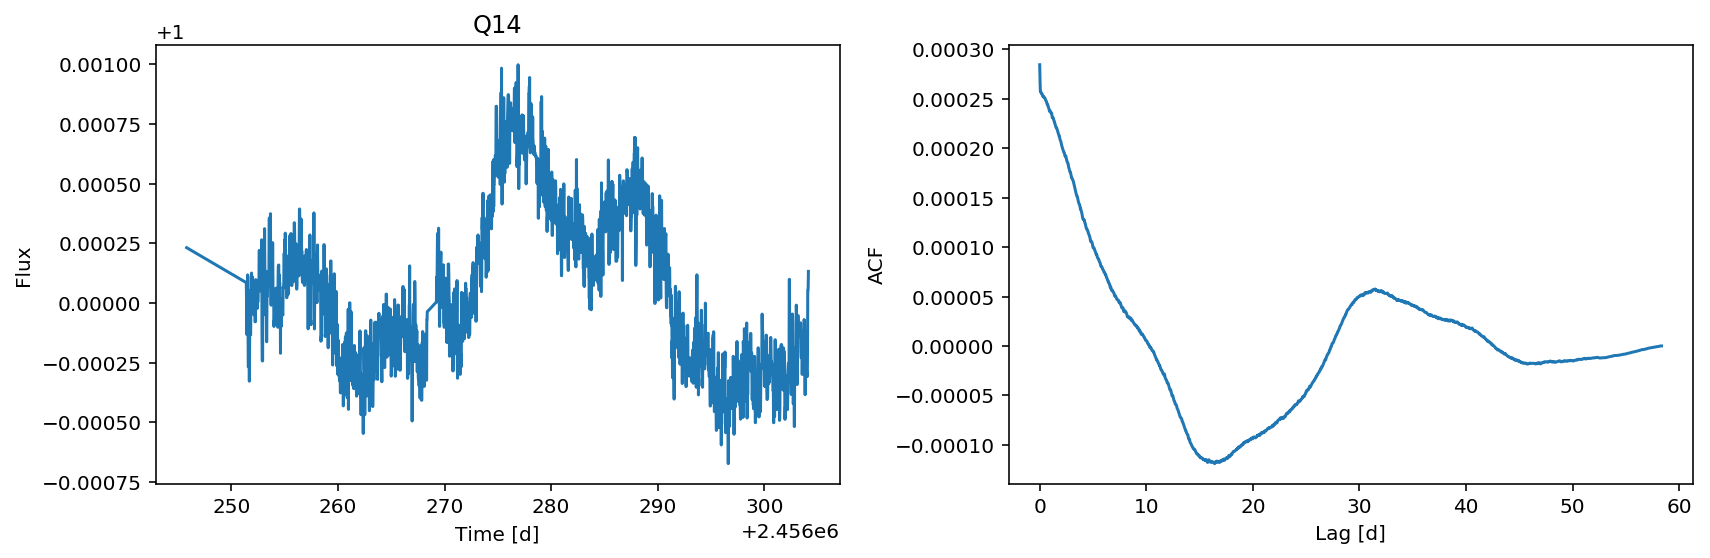

167


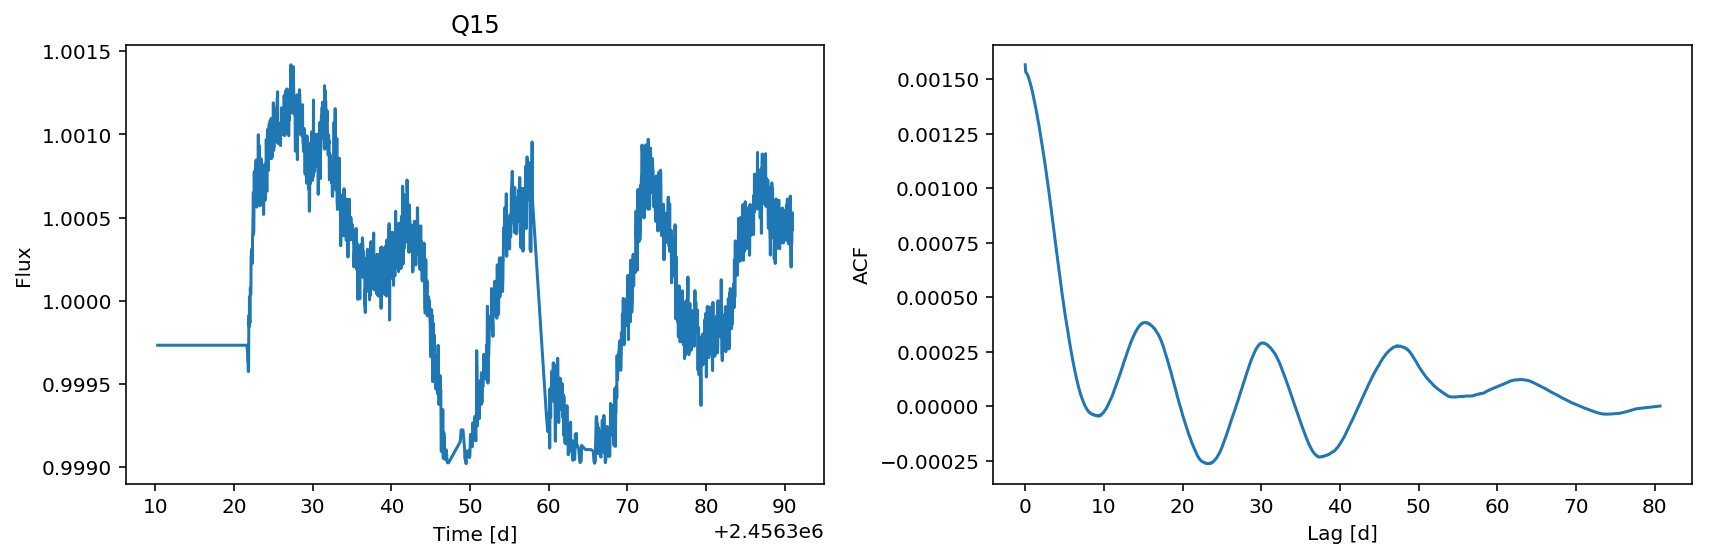

920


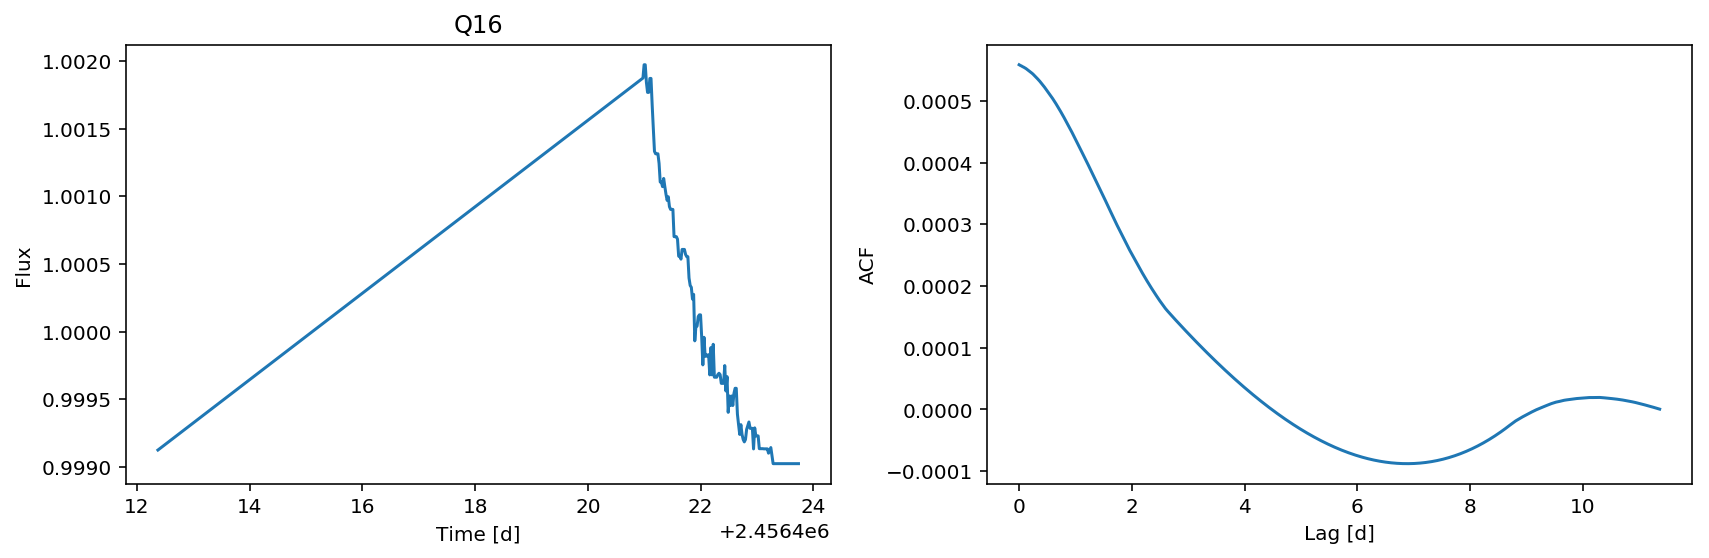

In [9]:
import kplr
client = kplr.API()

names = 'Kepler-62'
koi_number = 701

# Find the target KOI.
koi = client.koi(koi_number + 0.01)

# Get a list of light curve datasets.
lcs = koi.get_light_curves(short_cadence=False)

lags = []
acfs = []

# Loop over the datasets and read in the data.
time, flux, ferr, quality = [], [], [], []
for i, lc in enumerate(lcs):
    with lc.open() as f:
        # The lightcurve data are in the first FITS HDU.
        hdu_data = f[1].data
#         time.append(hdu_data["time"] + 2454833)
#         flux.append(hdu_data["sap_flux"])
#         ferr.append(hdu_data["sap_flux_err"])
#         quality.append(hdu_data["sap_quality"])

        time_q = hdu_data["time"] + 2454833
        flux_q = hdu_data["sap_flux"]
        err_q = hdu_data["sap_flux_err"]

        err_q /= np.nanmedian(flux_q)
        flux_q /= np.nanmedian(flux_q)
        not_nans = ~np.isnan(flux_q)
        p = np.polyfit(time_q[not_nans], flux_q[not_nans], 2)
        flux_q += 1 - np.polyval(p, time_q)

        flux_q = flux_q / k62_all_transits(time_q)[:, 0]

        mask_flares = ((flux_q < 0.999) | (flux_q > 1.002)) | np.isnan(time_q) | np.isnan(flux_q)

        flux_q = median_filter(flux_q[~mask_flares])
        time_q = time_q[~mask_flares] 
        # Find biggest chunk
        
        inds = np.argsort(np.diff(time_q))[-1]
        print(inds)
        time_q = time_q[inds:]
        flux_q = flux_q[inds:]
        
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        ax[0].plot(time_q, flux_q)
        ax[0].set(xlabel='Time [d]', ylabel='Flux', title='Q{0}'.format(i))
        sort = np.argsort(time_q)
        lag, acf = interpolated_acf(time_q[sort], flux_q[sort] - np.median(flux_q))
        lags.append(lag)
        acfs.append(acf)
        ax[1].plot(lag, acf)
        ax[1].set(xlabel='Lag [d]', ylabel='ACF')
        fig.tight_layout()
        plt.show()
# flux = median_filter(np.concatenate(flux))
# not_nans = ~np.isnan(flux) & ~np.isnan(np.concatenate(time))
# time = np.concatenate(time)[not_nans]
# err = np.concatenate(ferr)[not_nans]/np.nanmax(flux)
# flux = flux[not_nans]/np.percentile(flux[~np.isnan(flux)], 99)

# sort = np.argsort(time)
# time = time[sort]
# flux = flux[sort] / k62_all_transits(time)[:, 0]
# err = err[sort]

# mask_flares = (flux < 0.99) | (flux > 1.002)

# time = time[~mask_flares]
# flux = flux[~mask_flares]
# err = err[~mask_flares]

#np.savetxt('k296_medfilt.txt', np.vstack([time, flux, err]).T)

Text(0,0.5,'ACF')

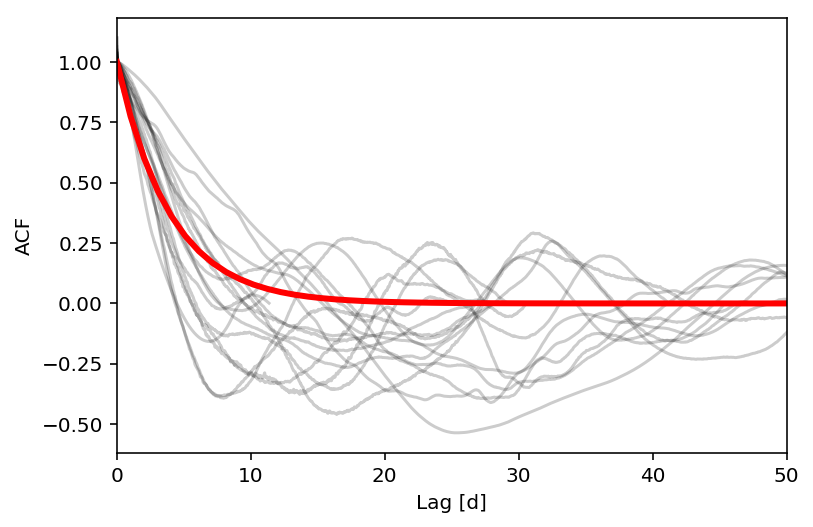

In [15]:
all_lags = np.array([])
all_acfs = np.array([])

for i, lag, acf in zip(range(len(lags)), lags, acfs):
    plt.plot(lag, acf/np.percentile(acf, 99.9), color='k', alpha=0.2)
    all_acfs = np.hstack([all_acfs, acf/np.percentile(acf, 99.9)])
    all_lags = np.hstack([all_lags, lag])

x = np.linspace(0, 50)
plt.plot(x, np.exp(-0.25 * x), lw=3, color='r')
plt.xlim([0, 50])
plt.xlabel('Lag [d]')
plt.ylabel('ACF')

Optimization terminated successfully.
         Current function value: 368.300556
         Iterations: 2
         Function evaluations: 40
Exponential term:  0.26661723877761523


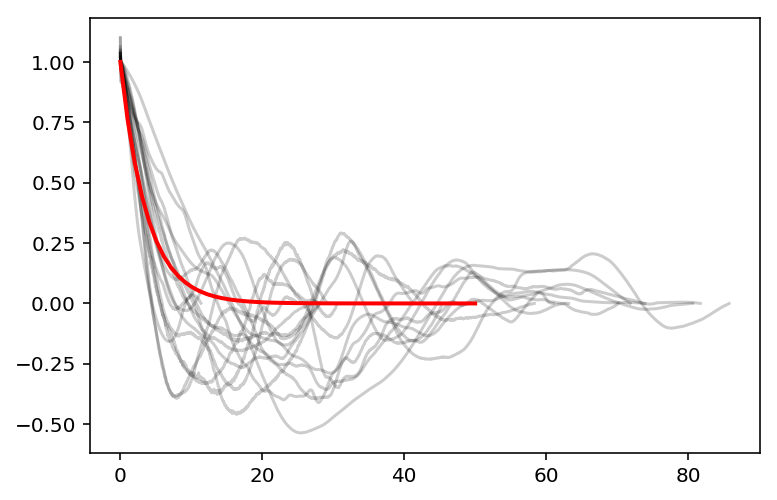

In [26]:
for i, lag, acf in zip(range(len(lags)), lags, acfs):
    plt.plot(lag, acf/np.percentile(acf, 99.9), color='k', alpha=0.2)

fit_limit = all_lags < 10

def model(p, lags):
    return np.exp(-lags * p[0])
    
def chi2(p, lags): 
    return np.sum((model(p, lags) - all_acfs[fit_limit])**2)

from scipy.optimize import fmin_powell

result = fmin_powell(chi2, [0.25], args=(all_lags[fit_limit],))

plt.plot(x, model([result], x), 'r', lw=2)

print("Exponential term: ", result)